In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import glob

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
images=glob.glob("../input/flickr8k/Images/*.jpg")
images[:5]

['../input/flickr8k/Images/3226254560_2f8ac147ea.jpg',
 '../input/flickr8k/Images/214543992_ce6c0d9f9b.jpg',
 '../input/flickr8k/Images/2366643786_9c9a830db8.jpg',
 '../input/flickr8k/Images/3368819708_0bfa0808f8.jpg',
 '../input/flickr8k/Images/2190227737_6e0bde2623.jpg']

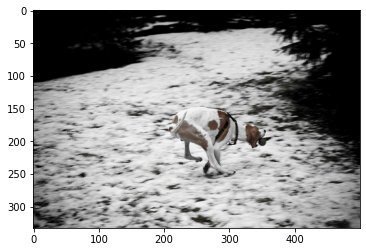

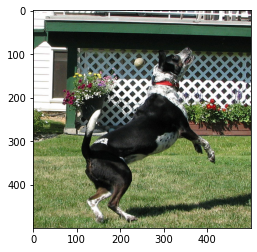

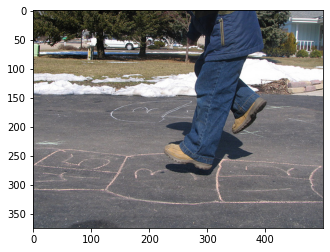

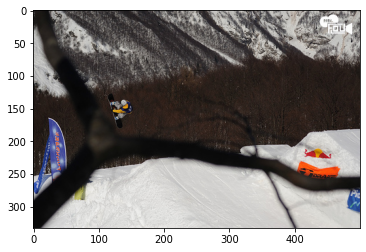

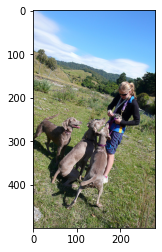

In [4]:
import matplotlib.pyplot as plt
for i in range(5):
    plt.figure()
    img=cv2.imread(images[i])
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [5]:
images[0].split("/")[-1][:-4]

'3226254560_2f8ac147ea'

In [6]:
#from keras.applications import ResNet50
incept_model=tf.keras.applications.ResNet50(include_top=True)
#tf.keras.applications.ResNet50

2022-05-16 06:54:48.409739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 06:54:48.534329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 06:54:48.535463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 06:54:48.537391: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

102981632/102967424 [==============================] - 1s 0us/step


In [7]:
#incept_model.summary()

In [8]:
from tensorflow.keras.models import Model
last=incept_model.layers[-2].output
modele=Model(inputs=incept_model.input,outputs=last)

In [9]:
image_features={}
count=1
for i in images:
    img=cv2.imread(i)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(224,224))
    img=img.reshape(1,224,224,3)
    pred=modele.predict(img).reshape(2048,)
    img_name=i.split("/")[-1]
    image_features[img_name]=pred
    count+=1
    if(count>2000):
        break
    else:
        if(count%500==0):
            print(count)

2022-05-16 06:54:54.807601: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-16 06:54:56.866866: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


500
1000
1500
2000


In [10]:
modele.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [11]:
text_path=open("../input/flickr8k/captions.txt","r")
text=text_path.read()
text_path.close()


In [12]:
text=text.split("\n")
#text

In [13]:
print(len(text))

40457


In [14]:
#print(image_features.keys())


In [15]:
print(text[:5])

['image,caption', '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']


In [16]:
dict={}
for i in range(1,len(text)-1):
    image_add=text[i].split(",")[0]
    caption=text[i].split(",")[1][:-1]
    if image_add not in image_features.keys():
        pass
    else:
        if image_add not in dict.keys():
            dict[image_add]=[caption]
        else:
            dict[image_add].append(caption)

In [17]:
print(len(dict.keys()))

2000


In [18]:
import string
sp=list(string.punctuation)
#sp

In [19]:
def fun(s):
    s=[x for x in s.split(" ")]
    s=[x for x in s if x.isalpha()]
    s=[x for x in s if len(x)>1]
    s=[x for x in s if x not in sp]
    s=[x.lower() for x in s]
    s=" ".join(s)
    s='startofseq'+" "+s+" "+'endofseq'
    return s    
      
    

In [20]:
#dict1={}
for key,value in dict.items():
    l=[]
    for x in value:
        l.append(fun(x))
    dict[key]=l

In [21]:
word_count={}
count=1
for k,v in dict.items():
    for vv in v:
        for words in vv.split(" "):
            if words not in word_count.keys():
                word_count[words]=count
                count+=1


In [22]:
VOCAB_SIZE=len(word_count)
VOCAB_SIZE

4693

In [23]:
for k,vv in dict.items():
    for v in vv:
        encoded=[]
        for word in v.split():
            if word not in word_count:
                encoded.append(10000)
            else:
                encoded.append(word_count[word])
        dict[k][vv.index(v)]=encoded

In [24]:
MAX_LEN=1
for k,v in dict.items():
    for vv in v:
        MAX_LEN=max(MAX_LEN,len(vv))
MAX_LEN
        

28

In [25]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [26]:
def generator(photo,caption):
    X=[]
    y_in=[]
    y_out=[]
    for k,vv in caption.items():
        for v in vv:
            for i in range(1,len(v)):
                X.append(photo[k])
                in_seq=[v[:i]]
                out_seq=v[i]
                in_seq=pad_sequences(in_seq,maxlen=MAX_LEN,padding="post",truncating="post")[0]
                out_seq=to_categorical([out_seq],num_classes=VOCAB_SIZE+1)[0]
                
                y_in.append(in_seq)
                y_out.append(out_seq)
    return X,y_in,y_out

In [27]:
X,y_in,y_out=generator(image_features,dict)

In [28]:
print(len(X))
print(len(y_in))
print(len(y_out))

98051
98051
98051


In [29]:
X=np.array(X)
y_in=np.array(y_in,dtype="float64")
y_out=np.array(y_out,dtype="float64")

In [30]:
print(X.shape)
print(y_in.shape)
print(y_out.shape)

(98051, 2048)
(98051, 28)
(98051, 4694)


In [31]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model,Sequential
#from keras.layers import Input, Flatten ,Dense,Conv2D,Embedding,Dropout,LSTM,TimeDistributed,Bidirectional,
#from keras.layes import Activation,RepeatVector,Concatenate
import tensorflow.keras.layers

In [32]:
embedding_size=128
image_model=Sequential()
image_model.add(keras.layers.Dense(embedding_size,input_shape=(2048,),activation="relu"))
image_model.add(keras.layers.RepeatVector(MAX_LEN))
image_model.summary()
lang_model=Sequential()
lang_model.add(keras.layers.Embedding(input_dim=VOCAB_SIZE,output_dim=embedding_size,input_length=MAX_LEN))
lang_model.add(keras.layers.LSTM(256,return_sequences=True))
lang_model.add(keras.layers.TimeDistributed(keras.layers.Dense(embedding_size)))
lang_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 28, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 28, 128)           600704    
_________________________________________________________________
lstm (LSTM)                  (None, 28, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 28, 128)           32896     
Total params: 1,027,840
Trai

In [33]:
conca=keras.layers.Concatenate()([image_model.output,lang_model.output])
x=keras.layers.LSTM(128,return_sequences=True)(conca)
x=keras.layers.LSTM(256,return_sequences=False)(x)
x=keras.layers.Dense((VOCAB_SIZE+1))(x)
out=keras.layers.Activation("softmax")(x)
model=keras.models.Model(inputs=[image_model.input,lang_model.input],outputs=[out])

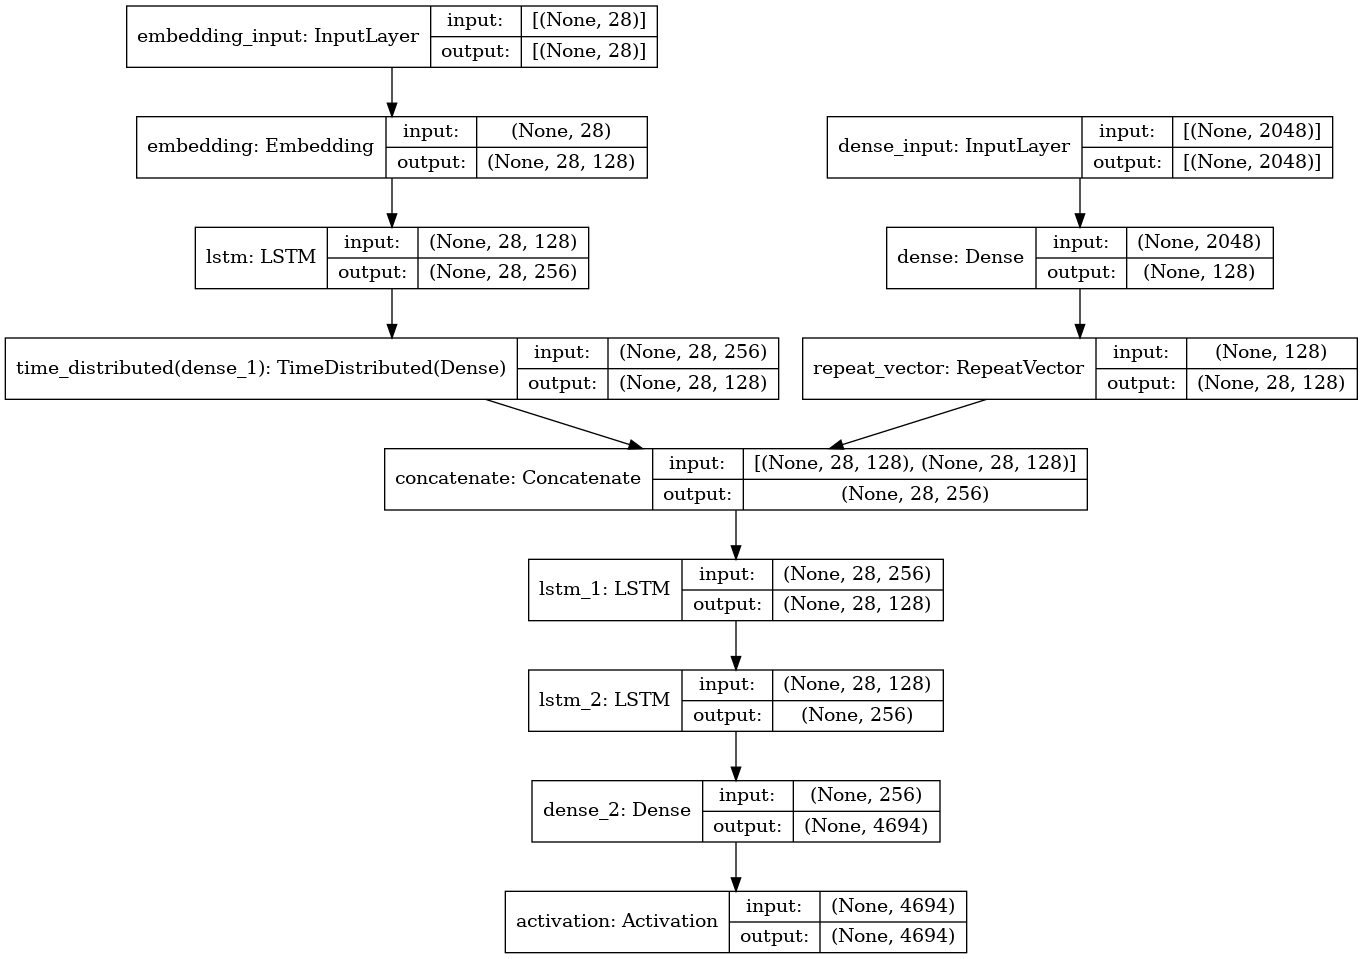

In [34]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [35]:
model.compile(loss="categorical_crossentropy",optimizer="RMSprop",metrics=["accuracy"])


In [36]:
history=model.fit([X,y_in],y_out,batch_size=512,epochs=20)

2022-05-16 06:57:32.784645: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1841005576 exceeds 10% of free system memory.
2022-05-16 06:57:34.833063: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1841005576 exceeds 10% of free system memory.


Epoch 1/20
192/192 [==============================] - 14s 40ms/step - loss: 5.6775 - accuracy: 0.1170
Epoch 2/20
192/192 [==============================] - 8s 40ms/step - loss: 5.1913 - accuracy: 0.1501
Epoch 3/20
192/192 [==============================] - 8s 40ms/step - loss: 4.9885 - accuracy: 0.1603
Epoch 4/20
192/192 [==============================] - 8s 41ms/step - loss: 4.8518 - accuracy: 0.1699
Epoch 5/20
192/192 [==============================] - 8s 40ms/step - loss: 4.7306 - accuracy: 0.1813
Epoch 6/20
192/192 [==============================] - 8s 40ms/step - loss: 4.6199 - accuracy: 0.1901
Epoch 7/20
192/192 [==============================] - 8s 41ms/step - loss: 4.5181 - accuracy: 0.1977
Epoch 8/20
192/192 [==============================] - 8s 40ms/step - loss: 4.4121 - accuracy: 0.2057
Epoch 9/20
192/192 [==============================] - 8s 41ms/step - loss: 4.2923 - accuracy: 0.2202
Epoch 10/20
192/192 [==============================] - 8s 40ms/step - loss: 4.1657 - accur

In [41]:
inv_dict={v:k for k,v in word_count.items()}

In [168]:
def getImage(x):
    test_image_path=(images[x])
    test_img=cv2.imread(test_image_path)
    test_img=cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img=cv2.resize(test_img,(224,224))
    test_img=np.reshape(test_img,(1,224,224,3))
    return test_img

In [169]:
img_no=5600
test_feature=modele.predict(getImage(img_no)).reshape(1,2048)
    

error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


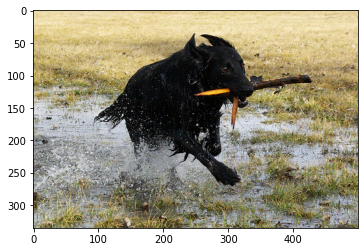

In [157]:

test_image_path=images[img_no]
test_img=cv2.imread(test_image_path)
test_img=cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
plt.imshow(test_img)
    


In [172]:
text_inp=["startofseq"]
count=0
caption=" "
while count<25:
        count+=1
        encoded=[]
        for i in text_inp:
            encoded.append(word_count[i])
        encoded=[encoded]
        encoded=pad_sequences(encoded,padding="post",truncating="post",maxlen=MAX_LEN)
        prediction=np.argmax(model.predict([test_feature,encoded]))
        sampled_word=inv_dict[prediction]
        if sampled_word=="endofseq":
            break
        else:
            text_inp.append(sampled_word)

In [173]:
text_inp=" ".join(text_inp[1:])
text_inp

'black dog is running through the sand'